<a href="https://colab.research.google.com/github/yashsawant22/Market-Prediction-Using-LSTM/blob/main/Project_Code.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Overview: https://www.kaggle.com/competitions/g-research-crypto-forecasting/overview

Detail: https://www.kaggle.com/code/cstein06/tutorial-to-the-g-research-crypto-competition/notebook

(API: https://www.kaggle.com/code/sohier/detailed-api-introduction/notebook)


## Forecasting returns
A fundamental task in financial modeling is predicting how prices will behave in the near future. Using the time-series of historical prices as training data, we want to predict if prices will go up or down, and by how much, namely the asset returns.

In this competition, Kagglers are challenged to build machine learning models to predict the returns of 14 popular cryptocurrencies, in the time scale of minutes to hours. You will have access to millions of rows of minute-by-minute cryptocurrency trading data, with which you'll design your forecasting models for all 14 assets simultaneously. Your predictions will be evaluated by how much they correlate with real market data collected during the three-month evaluation period after the competition has closed.

### train.csv - The training set

- timestamp: All timestamps are returned as second Unix timestamps (the number of seconds elapsed since 1970-01-01 00:00:00.000 UTC). Timestamps in this dataset are multiple of 60, indicating minute-by-minute data.
- Asset_ID: The asset ID corresponding to one of the crytocurrencies (e.g. Asset_ID = 1 for Bitcoin). The mapping from Asset_ID to crypto asset is contained in asset_details.csv.
- Count: Total number of trades in the time interval (last minute).
- Open: Opening price of the time interval (in USD).
- High: Highest price reached during time interval (in USD).
- Low: Lowest price reached during time interval (in USD).
- Close: Closing price of the time interval (in USD).
- Volume: Quantity of asset bought or sold, displayed in base currency USD.
- VWAP: The average price of the asset over the time interval, weighted by volume. VWAP is an aggregated form of trade data.
- Target: Residual log-returns for the asset over a 15 minute horizon.

In [ ]:
import pandas as pd
import numpy as np
from datetime import datetime
import scipy.stats as stats
import time
import matplotlib.pyplot as plt
import seaborn as sns
import lightgbm as lgb
import pickle
import gc
import plotly.graph_objects as go
from datetime import datetime

import warnings
warnings.filterwarnings('ignore')
# import warnings
# warnings.simplefilter(action='ignore', category=FutureWarning)

In [ ]:
from google.colab import drive
drive.mount("/content/drive")

MessageError: ignored

In [ ]:
data_folder = "drive/SharedWithMe/"
!ls $data_folder

ls: cannot access 'drive/SharedWithMe/': No such file or directory


In [ ]:
df = pd.read_csv(data_folder + 'train.csv',
                 dtype={'Asset_ID': 'int8', 'Count': 'int32', 'Count': 'int32',
                        'Open': 'float64', 'High': 'float64', 'Low': 'float64', 'Close': 'float64',
                        'Volume': 'float64', 'VWAP': 'float64'})

In [ ]:
df.summary()

In [ ]:
df.head(10)

,timestamp,Asset_ID,Count,Open,High,Low,Close,Volume,VWAP,Target
0,1514764860,2,40,2376.580000,2399.5000,2357.1400,2374.590000,19.233005,2373.116392,-0.004218
1,1514764860,0,5,8.530000,8.5300,8.5300,8.530000,78.380000,8.530000,-0.014399
2,1514764860,1,229,13835.194000,14013.8000,13666.1100,13850.176000,31.550062,13827.062093,-0.014643
3,1514764860,5,32,7.659600,7.6596,7.6567,7.657600,6626.713370,7.657713,-0.013922
4,1514764860,7,5,25.920000,25.9200,25.8740,25.877000,121.087310,25.891363,-0.008264
5,1514764860,6,173,738.302500,746.0000,732.5100,738.507500,335.987856,738.839291,-0.004809
6,1514764860,9,167,225.330000,227.7800,222.9800,225.206667,411.896642,225.197944,-0.009791
7,1514764860,11,7,329.090000,329.8800,329.0900,329.460000,6.635710,329.454118,NaN
8,1514764920,2,53,2374.553333,2400.9000,2354.2000,2372.286667,24.050259,2371.434498,-0.004079
9,1514764920,0,7,8.530000,8.5300,8.5145,8.514500,71.390000,8.520215,-0.015875


In [ ]:
id = df.Asset_ID.unique()
id.sort()
id

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13], dtype=int8)

In [ ]:
# df.columns

### 14 cryptocurrencies data

In [ ]:
asset_details = pd.read_csv(data_folder + 'asset_details.csv')
# asset_details
asset_details = asset_details.sort_values('Asset_ID')
asset_details = asset_details.reset_index(drop=True)

In [ ]:
# split data by assets
bnn = df[df["Asset_ID"]==0].set_index("timestamp")  # Binance Coin
btc = df[df["Asset_ID"]==1].set_index("timestamp")  # Bitcoin
btcc = df[df["Asset_ID"]==2].set_index("timestamp")  # Bitcoin Cash
crd = df[df["Asset_ID"]==3].set_index("timestamp")  # Cardano
doge = df[df["Asset_ID"]==4].set_index("timestamp")  # Dogecoin
eos = df[df["Asset_ID"]==5].set_index("timestamp")  # EOS.IO
eth = df[df["Asset_ID"]==6].set_index("timestamp")  # Ethereum
ethc = df[df["Asset_ID"]==7].set_index("timestamp")  # Ethereum Classic
iota = df[df["Asset_ID"]==8].set_index("timestamp")  # IOTA
lite = df[df["Asset_ID"]==9].set_index("timestamp")  # Litecoin
maker = df[df["Asset_ID"]==10].set_index("timestamp")  # Maker
mon = df[df["Asset_ID"]==11].set_index("timestamp")  # Monero
stl = df[df["Asset_ID"]==12].set_index("timestamp")  # Stellar
tron = df[df["Asset_ID"]==13].set_index("timestamp")  # TRON

In [ ]:
# for reference
btc.info(show_counts=True)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1956282 entries, 1514764860 to 1632182400
Data columns (total 9 columns):
 #   Column    Non-Null Count    Dtype  
---  ------    --------------    -----  
 0   Asset_ID  1956282 non-null  int8   
 1   Count     1956282 non-null  int32  
 2   Open      1956282 non-null  float64
 3   High      1956282 non-null  float64
 4   Low       1956282 non-null  float64
 5   Close     1956282 non-null  float64
 6   Volume    1956282 non-null  float64
 7   VWAP      1956282 non-null  float64
 8   Target    1955978 non-null  float64
dtypes: float64(7), int32(1), int8(1)
memory usage: 128.7 MB


## Visualization of recent Bitcoin data using candlestick charts

- Length represents the price range between the open and close of that day's trading.
- When the bar is red, it means the close was lower than the open, and green otherwise.
- The wicks above and below the bars show the high and low prices of that interval's trading.
- The bottom part of the plot shows a rangeslider to zoom in the plot.

In [ ]:
# select recent data
btc_recent = btc.iloc[-200:]

In [ ]:
fig = go.Figure(data=[go.Candlestick(x=btc_recent.index, open=btc_recent['Open'], high=btc_recent['High'], low=btc_recent['Low'], close=btc_recent['Close'])])
fig.show()

## Preprocessing

### Dealing with missing data

- Missing asset data, for a given minute, is not represented by NaN's, but instead by the absence of those rows. Can check the timestamp difference between consecutive rows to see if there is missing data.

In [ ]:
assets = [bnn, btc, btcc, crd, doge, eos, eth, ethc, iota, lite, maker, mon, stl, tron]

for i in assets:
  # check the time gaps
  print((i.index[1:] - i.index[:-1]).value_counts().head())
  i += 1

In [ ]:
bnn = bnn.reindex(range(bnn.index[0], bnn.index[-1]+60,60), method='pad')
btc = btc.reindex(range(btc.index[0], btc.index[-1]+60,60), method='pad')
btcc = btcc.reindex(range(btcc.index[0], btcc.index[-1]+60,60), method='pad')
crd = crd.reindex(range(crd.index[0], crd.index[-1]+60,60), method='pad')
doge = doge.reindex(range(doge.index[0], doge.index[-1]+60,60), method='pad')
eos = eos.reindex(range(eos.index[0], eos.index[-1]+60,60), method='pad')
eth = eth.reindex(range(eth.index[0], eth.index[-1]+60,60), method='pad')
ethc = ethc.reindex(range(ethc.index[0], ethc.index[-1]+60,60), method='pad')
iota = iota.reindex(range(iota.index[0], iota.index[-1]+60,60), method='pad')
lite = lite.reindex(range(lite.index[0], lite.index[-1]+60,60), method='pad')
maker = maker.reindex(range(maker.index[0], maker.index[-1]+60,60), method='pad')
mon = mon.reindex(range(mon.index[0], mon.index[-1]+60,60), method='pad')
stl = stl.reindex(range(stl.index[0], stl.index[-1]+60,60), method='pad')
tron = tron.reindex(range(tron.index[0], tron.index[-1]+60,60), method='pad')

In [ ]:
# check
(tron.index[1:] - tron.index[:-1]).value_counts().head()

## Visualization for the support

In order to analyze price changes for an asset we can deal with the price difference. However, different assets exhibit different price scales, so that the their returns are not readily comparable. We can solve this problem by computing the percentage change in price instead, also known as the return. This return coincides with the percentage change in our invested capital.

Returns are widely used in finance, however log returns are preferred for mathematical modelling of time series, as they are additive across time. Also, while regular returns cannot go below -100%, log returns are not bounded.

To compute the log return, we can simply take the logarithm of the ratio between two consecutive prices. The first row will have an empty return as the previous value is unknown, therefore the empty return data point will be dropped.

### Log returns

### Correlation matrix

In [ ]:
# create dataframe with returns for all assets
all_assets_2021 = pd.DataFrame([])
for asset_id, asset_name in zip(asset_details.Asset_ID, asset_details.Asset_Name):
  asset = df[df["Asset_ID"]==asset_id].set_index("timestamp")
  asset = asset.loc[totimestamp('12/01/2021'):totimestamp('12/05/2021')]
  asset = asset.reindex(range(asset.index[0],asset.index[-1]+60,60),method='pad')
  lret = log_return(asset.Close.fillna(0))[1:]
  all_assets_2021 = all_assets_2021.join(lret, rsuffix=asset_name, how="outer")

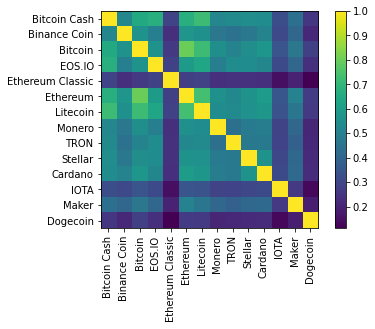

In [ ]:
plt.imshow(all_assets_2021.corr());
plt.yticks(range(14), asset_details.Asset_Name.values);
plt.xticks(range(14), asset_details.Asset_Name.values, rotation='vertical');
plt.colorbar();

The matrix indicates the correlation between all assets.  
Highlights:
- Ethereum and Bitcoin are relatively highly correlated.
- Ethereum Classic, IOTA, and Dogecoin are barely correlated to others.

## Building a prediction model

### Feature engineering

https://www.kaggle.com/code/cstein06/tutorial-to-the-g-research-crypto-competition?scriptVersionId=84976518&cellId=51

y = Target, which is derived from log returns over 15 minutes.  

Some rows have null values for targets due to missing values in future prices. Rows with nulls in the test set ground truth are ignored for scoring purposes.

In the competition, your predictions will be evaluated on a weighted version of the Pearson correlation coefficient, with weights given by the Weight column in the Asset Details file.

In [ ]:
def reduce_mem_usage(df):
    """ iterate through all the columns of a dataframe and modify the data type
        to reduce memory usage.
    """
    start_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage of dataframe is {:.2f} MB'.format(start_mem))

    for col in df.columns:
        col_type = df[col].dtype

        c_min = df[col].min()
        c_max = df[col].max()
        if str(col_type)[:3] == 'int':
            if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                df[col] = df[col].astype(np.int8)
            elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                df[col] = df[col].astype(np.int16)
            elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                df[col] = df[col].astype(np.int32)
            elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                df[col] = df[col].astype(np.int64)
        else:
            if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                df[col] = df[col].astype(np.float16)
            elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                df[col] = df[col].astype(np.float32)
            else:
                df[col] = df[col].astype(np.float64)

    end_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage after optimization is: {:.2f} MB'.format(end_mem))
    print('Decreased by {:.1f}%'.format(100 * (start_mem - end_mem) / start_mem))

    return df

In [ ]:
#Building general model for market movement ignoring individual crypto coins

In [ ]:
seed0 = 0
params = {
    'early_stopping_rounds': 50,
    'objective': 'regression',
    'metric': 'rmse',
    'boosting_type': 'gbdt',
    'max_depth': 10,
    'verbose': -1,
    'max_bin':600,
    'min_data_in_leaf':50,
    'learning_rate': 0.03,
    'subsample': 0.7,
    'subsample_freq': 1,
    'feature_fraction': 1,
    'lambda_l1': 0.5,
    'lambda_l2': 1,
    'seed':seed0,
    'feature_fraction_seed': seed0,
    'bagging_fraction_seed': seed0,
    'drop_seed': seed0,
    'data_random_seed': seed0,
    'extra_trees': True,
    'extra_seed': seed0,
    'zero_as_missing': True,
    "first_metric_only": True
         }

In [ ]:
from lightgbm import LGBMRegressor
import lightgbm as lgb

# define function to compute log returns
def log_return(series, periods = 1):
    return (np.log(abs(series))*np.sign(series)).diff(periods=periods)

# auxiliary function, from datetime to timestamp
totimestamp = lambda s: np.int32(time.mktime(datetime.strptime(s, "%d/%m/%Y").timetuple()))

def plot_importance(importances, features_names, PLOT_TOP_N = 20, figsize=(10, 10)):
    importance_df = pd.DataFrame(data=importances, columns=features_names)
    sorted_indices = importance_df.median(axis=0).sort_values(ascending=False).index
    sorted_importance_df = importance_df.loc[:, sorted_indices]
    plot_cols = sorted_importance_df.columns[:PLOT_TOP_N]
    _, ax = plt.subplots(figsize=figsize)
    ax.grid()
    ax.set_xscale('log')
    ax.set_ylabel('Feature')
    ax.set_xlabel('Importance')
    sns.boxplot(data=sorted_importance_df[plot_cols],
                orient='h',
                ax=ax)
    plt.show()

def sample_data(df, assit_id = None, startDate = '01/01/2020', endDate = '01/01/2021'):
  if assit_id:
    df = df[df["Asset_ID"] == assit_id].set_index("timestamp")
  else:
    df = df.groupby("timestamp", as_index=True).mean()
  #df = df.drop("Asset_ID", axis=1)
  df = df.reindex(range(df.index[0],df.index[-1]+60,60),method='pad')
  df = df.loc[totimestamp(startDate):totimestamp(endDate)]
  return df

# define the evaluation metric
def correlation(a, train_data):

    b = train_data.get_label()

    a = np.ravel(a)
    b = np.ravel(b)

    len_data = len(a)
    mean_a = np.sum(a) / len_data
    mean_b = np.sum(b) / len_data
    var_a = np.sum(np.square(a - mean_a)) / len_data
    var_b = np.sum(np.square(b - mean_b)) / len_data

    cov = np.sum((a * b))/len_data - mean_a*mean_b
    corr = cov / np.sqrt(var_a * var_b)

    return 'corr', corr, True

# Two new features from the competition tutorial
def upper_shadow(df):
    return df['High'] - np.maximum(df['Close'], df['Open'])

def lower_shadow(df):
    return np.minimum(df['Close'], df['Open']) - df['Low']

def feature_select(df):
    df = df[['Close', 'Open', 'High', 'Low','Volume', 'VWAP','Target']]#'Open', 'High', 'Low','Volume', 'VWAP',
    df['LogReturnOpen(5)'] = log_return(df.Open, 5)
    df['LogReturnOpen(15)'] = log_return(df.Open, 15)
    df['LogReturnClose(5)'] = log_return(df.Close, 5)
    df['LogReturnClose(15)'] = log_return(df.Close, 15)
    df['LogReturnHigh(5)'] = log_return(df.High-df.Open, 5)
    df['LogReturnHigh(15)'] = log_return(df.High-df.Open, 15)
    df['LogReturnOpen(1)'] = log_return(df.Open, 1)
    df['LogReturnOpen(3)'] = log_return(df.Open, 3)
    df['LogReturnClose(1)'] = log_return(df.Close, 1)
    df['LogReturnClose(3)'] = log_return(df.Close, 3)
    df['LogReturnHigh(1)'] = log_return(df.High-df.Open, 1)
    df['LogReturnHigh(3)'] = log_return(df.High-df.Open, 3)
    df['MAClose21'] = df['Close'].rolling(21).mean()
    df['MAClose7'] = df['Close'].rolling(7).mean()
    df['LogReturnLow(5)'] = log_return(df.Low-df.Open, 5)
    df['LogReturnLow(15)'] = log_return(df.Low-df.Open, 15)
    df['Upper_Shadow'] = upper_shadow(df)
    df['Lower_Shadow'] = lower_shadow(df)
    #df = df.drop(["Close","Open", "High", "Low", "VWAP"], axis=1)#"Open", "High", "Low", "VWAP"
    return df

def split_Data(df, splits = 5):
  start = df.index.start
  stop = df.index.stop
  stepSize = int((stop - start)/splits)
  #stepSize -= stepSize%60
  splits = [(start + stepSize*i, start + stepSize*(i+1)) for i in range(splits)]
  return splits

def train(df, asset_id = None, splits = None, printIt = True):
    dataSplits = split_Data(df, splits)
    importances = []
    oof_pred = []
    oof_valid = []
    for split in range(splits):
      training = dataSplits[:split] + dataSplits[split+1:]
      trainingData = []
      for tup in training:
        trainingData.append(df.loc[list(range(tup[0],tup[1]))])
      trainingData = pd.concat(trainingData)
      validation = dataSplits[split]
      validationData = df.loc[list(range(validation[0],validation[1]))]
      X_train, y_train = trainingData[trainingData.columns[:-1]], trainingData[trainingData.columns[-1]]
      train_dataset = lgb.Dataset(X_train,
                                    y_train.values,
                                    feature_name = list(X_train.columns),
                                   )

      X_val, y_val = validationData[validationData.columns[:-1]], validationData[validationData.columns[-1]]
      val_dataset = lgb.Dataset(X_val,
                                    y_val.values,
                                    feature_name = list(X_val.columns),
                                    )
      if printIt:
        print("doing split {} out of {}".format(split+1, splits))
        print(f"number of train data: {len(X_train)}")
        print(f"number of val data:   {len(X_val)}")

      model = lgb.train(params = params,
                          train_set = train_dataset,
                          valid_sets=[train_dataset, val_dataset],
                          valid_names=['tr', 'vl'],
                          num_boost_round = 5000,
                          verbose_eval = 100,
                          feval = correlation,
                         )
      importances.append(model.feature_importance(importance_type='gain'))
      #file = f'trained_model_id{asset_id}_fold{split}.pkl'
      #pickle.dump(model, open(file, 'wb'))
      #print(f"Trained model was saved to 'trained_model_id{asset_id}_fold{split}.pkl'")
      print("")

      oof_pred += list(model.predict(X_val))
      oof_valid += list(y_val.values)
    if printIt:
      print(importances)
      plot_importance(np.array(importances),X_train.columns, PLOT_TOP_N = 40, figsize=(10, 5))
    return oof_pred, oof_valid

In [ ]:
#Feature engineer expected return based on other cryptos

def testFeatureTimePrevail(df, myDic, target = "Target", assit_id = 0, startDate = '01/01/2020', endDate = '01/01/2021'):
  feature, func, i, selected = myDic[0]
  if feature == None:
    feature = target
  xTargetPred = df[["timestamp","Asset_ID", feature]]
  xTargetPred = xTargetPred.pivot(index="timestamp", columns='Asset_ID', values=feature)
  xTargetPred = xTargetPred[selected]
  if func:
    rename = lambda x : "{}({})({}-{})".format(func.__name__,feature,x,i)
    xTargetPred.columns = [rename(x) for x in xTargetPred.columns]
    orig = xTargetPred.columns
    for col in orig:
      xTargetPred[col] = func(xTargetPred[col],i)
    #xTargetPred = xTargetPred.drop(orig, axis=1)
  else:
    rename = lambda x : "{}({})".format(feature,x)
    xTargetPred.columns = [rename(x) for x in xTargetPred.columns]
  if len(myDic) > 1:
    for feature, func, i, selected in myDic[1:]:
      temp = df[["timestamp","Asset_ID", feature]]
      temp = temp.pivot(index="timestamp", columns='Asset_ID', values=feature)
      temp = temp[selected]
      if func:
        rename = lambda x : "{}({})({}-{})".format(func.__name__,feature,x,i)
        temp.columns = [rename(x) for x in temp.columns]
        orig = temp.columns
        for col in orig:
          temp[col] = func(temp[col],i)
      else:
        rename = lambda x : "{}({})".format(feature,x)
        temp.columns = [rename(x) for x in temp.columns]
      xTargetPred = pd.merge(xTargetPred, temp, how="inner", on=["timestamp"])
  yTargetPred = df[df["Asset_ID"]==assit_id][["timestamp",target]]
  targetPred = pd.merge(xTargetPred, yTargetPred, how="inner", on=["timestamp"]).set_index("timestamp")
  targetPred.columns = targetPred.columns.astype(str)
  targetPred = targetPred.reindex(range(targetPred.index[0],targetPred.index[-1]+60,60),method='pad')
  targetPred = targetPred.loc[totimestamp(startDate):totimestamp(endDate)]
  xTargetPred = targetPred[targetPred.columns[:-1]].iloc[:-1].reset_index(drop=True)
  #xTargetPred = xTargetPred.drop(["timestamp"], axis=1)
  yTargetPred = targetPred[targetPred.columns[-1]].iloc[1:].reset_index(drop=True)
  dfSample = pd.concat([xTargetPred, yTargetPred], axis=1)
  dfSample = dfSample.interpolate(method='nearest')
  dfSampletest = dfSample.fillna(0)
  #dfSample2 = reduce_mem_usage(dfSample.copy())
  oof_pred, oof_valid = train(dfSampletest,splits=12)
  #print(oof_pred)
  #print(oof_valid)
  return corr_score(np.array(oof_pred),np.array(oof_valid)), dfSampletest

In [ ]:
# For CV score calculation
def corr_score(pred, valid):
    len_data = len(pred)
    mean_pred = np.sum(pred) / len_data
    mean_valid = np.sum(valid) / len_data
    var_pred = np.sum(np.square(pred - mean_pred)) / len_data
    var_valid = np.sum(np.square(valid - mean_valid)) / len_data

    cov = np.sum((pred * valid))/len_data - mean_pred*mean_valid
    corr = cov / np.sqrt(var_pred * var_valid)

    return corr

# For CV score calculation
def wcorr_score(pred, valid, weight):
    len_data = len(pred)
    sum_w = np.sum(weight)
    mean_pred = np.sum(pred * weight) / sum_w
    mean_valid = np.sum(valid * weight) / sum_w
    var_pred = np.sum(weight * np.square(pred - mean_pred)) / sum_w
    var_valid = np.sum(weight * np.square(valid - mean_valid)) / sum_w

    cov = np.sum((pred * valid * weight)) / sum_w - mean_pred*mean_valid
    corr = cov / np.sqrt(var_pred * var_valid)

    return corr

In [ ]:
df["High-Low"] = df["High"]-df["Low"]
df['Upper_Shadow'] = upper_shadow(df)
df['Lower_Shadow'] = lower_shadow(df)

doing split 1 out of 12
number of train data: 483120
number of val data:   43920
Training until validation scores don't improve for 50 rounds
[100]	tr's rmse: 0.0016695	tr's corr: 0.116369	vl's rmse: 0.00134194	vl's corr: 0.0180946
Early stopping, best iteration is:
[59]	tr's rmse: 0.0016713	tr's corr: 0.107001	vl's rmse: 0.00134177	vl's corr: 0.0181248
Evaluated only: rmse

doing split 2 out of 12
number of train data: 483120
number of val data:   43920
Training until validation scores don't improve for 50 rounds
[100]	tr's rmse: 0.00167187	tr's corr: 0.12427	vl's rmse: 0.0013049	vl's corr: 0.0547579
Early stopping, best iteration is:
[84]	tr's rmse: 0.00167261	tr's corr: 0.119994	vl's rmse: 0.00130465	vl's corr: 0.0611156
Evaluated only: rmse

doing split 3 out of 12
number of train data: 483120
number of val data:   43920
Training until validation scores don't improve for 50 rounds
[100]	tr's rmse: 0.00156226	tr's corr: 0.116678	vl's rmse: 0.00237807	vl's corr: 0.0171857
Early stopp

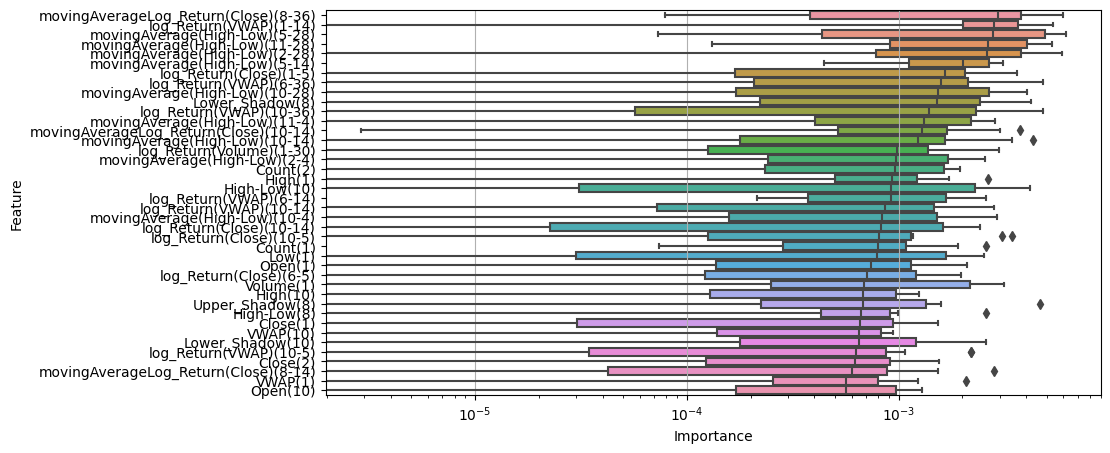

In [ ]:
corr = []

def log_Return(series,i):
  return (np.log(abs(series))*np.sign(series)).diff(periods=i)

def movingAverage(col, i):
  return col.rolling(i).mean()#log_return(col,1).rolling(i).mean()

def movingAverageLog_Return(col, i):
  return log_return(col,1).rolling(i).mean()

myDic = [[col, None, None, [1,2,8,10]] for col in df.columns[:-3]] + [["High-Low",movingAverage,4,[2,5,10,11]],
         ["High-Low",movingAverage,14,[5,10]],
         ["High-Low",movingAverage,28,[2,5,10,11]],
         ["Close",movingAverageLog_Return,14,[8,10,4]],
         ["Close",movingAverageLog_Return,36,[8,10,4]],
         ["Close",log_Return,5,[6,10,1]],
         ["Close",log_Return,14,[10]],
         ["Volume",log_Return,14,[10,1]],
         ["Volume",log_Return,30,[8,10,1]],
         ["VWAP",log_Return,5,[6,10]],
         ["VWAP",log_Return,14,[6,10,1]],
         ["VWAP",log_Return,36,[6,10]]]
corr, testDF = testFeatureTimePrevail(df, myDic, assit_id = 1)

In [ ]:
df = df[[col for col in df.columns if col not in ["timestamp", "Asset_ID","Target"]] + ["timestamp", "Asset_ID","Target"]]

In [ ]:
df.columns[:-3]

Index(['Count', 'Open', 'High', 'Low', 'Close', 'Volume', 'VWAP', 'High-Low',
       'Upper_Shadow', 'Lower_Shadow'],
      dtype='object')

In [ ]:
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant


X = testDF[testDF.columns[:-1]]
X = X.dropna()
X[~np.isfinite(X)] = 0
X = add_constant(X)

vif = pd.Series([variance_inflation_factor(X.values, i)
               for i in range(X.shape[1])],
              index=X.columns)

# VIF dataframe
#vif_data = pd.DataFrame()
#vif_data["feature"] = X.columns[:-1]

# calculating VIF for each feature
#vif_data["VIF"] = [variance_inflation_factor(X[:,:-1], i)
#                          for i in range(len(X.columns[:-1]))]

In [ ]:
vif.sort_values(ascending=False).head(40)

Upper_Shadow(10)                          inf
Low(2)                                    inf
High-Low(2)                               inf
High-Low(1)                               inf
Upper_Shadow(1)                           inf
Upper_Shadow(2)                           inf
Lower_Shadow(1)                           inf
Close(10)                                 inf
Close(8)                                  inf
Close(2)                                  inf
Close(1)                                  inf
High-Low(10)                              inf
Low(8)                                    inf
Low(10)                                   inf
Low(1)                                    inf
Open(8)                                   inf
Lower_Shadow(10)                          inf
Lower_Shadow(2)                           inf
High(10)                                  inf
Open(2)                                   inf
Open(1)                                   inf
Open(10)                          

In [ ]:
#Lstm
!pip install keras-tcn

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 14.5 MB/s eta 0:00:00


In [ ]:
import keras
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()
from keras.preprocessing.sequence import TimeseriesGenerator
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from tcn import TCN, tcn_full_summary
from tensorflow.keras.layers import Dense, add, Lambda, GlobalMaxPooling1D, GlobalAveragePooling1D, concatenate, LSTM
from tensorflow.keras import Input, Model, backend
from tensorflow.keras.losses import binary_crossentropy
from sklearn import preprocessing

#Preprocess
dfSample = sample_data(df.copy(), assit_id = 1, startDate = '01/01/2020', endDate = '01/03/2020')
dfSample1 = feature_select(dfSample.copy())
dfSample1 = reduce_mem_usage(dfSample1)
dfSample1.interpolate(method='nearest')
dfSample1 = dfSample1.reindex(columns = [col for col in dfSample1.columns if col != 'Target'] + ['Target'])
dfSample1 = dfSample1.fillna(0)
dfSample1.replace([np.inf, -np.inf], 0, inplace=True)
scaler = preprocessing.MinMaxScaler()
dfSample1_fitted = scaler.fit_transform(dfSample1[dfSample1.columns[:-1]])
#dfSample1_fitted = reduce_mem_usage(pd.DataFrame((dfSample1_fitted))
X_train, y_train = dfSample1_fitted[:,:-1], dfSample1[dfSample1.columns[-1]].values/max(dfSample1["Target"].max(),abs(dfSample1["Target"].min()))

Memory usage of dataframe is 6.59 MB
Memory usage after optimization is: 1.65 MB
Decreased by 75.0%


In [ ]:
y_train

array([0.06915,     nan,     nan, ..., 0.09985, 0.0957 , 0.0957 ],
      dtype=float16)

In [ ]:
max(dfSample1["Target"].max(),abs(dfSample1["Target"].min()))

0.03458

In [ ]:
#Create generator
n_input = 180 #how many samples/rows/timesteps to look in the past in order to forecast the next sample
n_features= X_train.shape[1] # how many predictors/Xs/features we have to predict y
b_size = 256 # Number of timeseries samples in each batch
y_T, X_T, y_V, X_V = y_train[:-12749], X_train[:-12749], y_train[-12749:-25], X_train[-12749:-25]
generator = TimeseriesGenerator(X_T, y_T, length=n_input, batch_size=b_size, shuffle=False)
generator_validation = TimeseriesGenerator(X_V, y_V, length=n_input, batch_size=b_size, shuffle=False)

In [ ]:
#Build and run model
i = Input(batch_shape=(b_size, n_input, n_features))
x1 = TCN(return_sequences=True, nb_filters=64, dilations = [1, 2, 4, 8, 16, 32], nb_stacks=1, dropout_rate=.1, kernel_size=3)(i)
x2 = Lambda(lambda z: backend.reverse(z, axes=0))(i)
x2 = TCN(return_sequences=True, nb_filters=64, dilations = [1, 2, 4, 8, 16, 32], nb_stacks=1, dropout_rate=.2, kernel_size=3)(x2)
x = add([x1, x2])
x = LSTM(8, dropout=.1)(x)
o = Dense(1, activation='linear')(x)
m = Model(inputs=i, outputs=o)
m.compile(optimizer='adam', loss='mse')
history = m.fit_generator(generator=generator,
                    validation_data=generator_validation, epochs=10)
#history = m.fit(generator,epochs=5, validation_split = 0.05)

Epoch 1/10
287/287 [==============================] - 1267s 4s/step - loss: 0.0033 - val_loss: 0.0012
Epoch 2/10
287/287 [==============================] - 1242s 4s/step - loss: 0.0015 - val_loss: 0.0012
Epoch 3/10
287/287 [==============================] - 1259s 4s/step - loss: 0.0015 - val_loss: 0.0012
Epoch 4/10
287/287 [==============================] - 1259s 4s/step - loss: 0.0015 - val_loss: 0.0012
Epoch 5/10
287/287 [==============================] - 1248s 4s/step - loss: 0.0015 - val_loss: 0.0012
Epoch 6/10
287/287 [==============================] - 1257s 4s/step - loss: 0.0015 - val_loss: 0.0012
Epoch 7/10
287/287 [==============================] - 1245s 4s/step - loss: 0.0015 - val_loss: 0.0012
Epoch 8/10
 45/287 [===>..........................] - ETA: 16:23 - loss: 0.0016

KeyboardInterrupt: ignored

In [ ]:
file = f'drive/Shareddrives/273_ML_Project/g-research-crypto-forecasting/trained_model_30Window_TCN'
pickle.dump(m, open(file, 'wb'))
print(f"Trained model was saved to 'trained_model_id{0}_TCN.pkl'")

Keras weights file (<HDF5 file "variables.h5" (mode r+)>) saving:
...layers
......add
.........vars
......dense
.........vars
............0
............1
......input_layer
.........vars
......lambda
.........vars
......lstm
.........cell
............vars
...............0
...............1
...............2
.........vars
......tcn
.........residual_block_0
............Act_Conv1D_0
...............vars
............Act_Conv1D_1
...............vars
............Act_Conv_Blocks
...............vars
............Act_Res_Block
...............vars
............SDropout_0
...............vars
............SDropout_1
...............vars
............conv1D_0
...............vars
..................0
..................1
............conv1D_1
...............vars
..................0
..................1
............matching_conv1D
...............vars
..................0
..................1
............vars
.........residual_block_1
............Act_Conv1D_0
...............vars
............Act_Conv1D_1
...........

In [ ]:
m.save("drive/Shareddrives/273_ML_Project/g-research-crypto-forecasting/trained_model_2_TCN")

In [ ]:
#m = pickle.load(open("trained_model_id0_TCN.pkl", 'rb'))
#Preprocess Test
dfSample = sample_data(df.copy(), assit_id = 0, startDate = '02/03/2021', endDate = '01/04/2021')
dfSample1 = feature_select(dfSample.copy())
dfSample1 = reduce_mem_usage(dfSample1)
dfSample1.interpolate(method='nearest')
dfSample1 = dfSample1.reindex(columns = [col for col in dfSample1.columns if col != 'Target'] + ['Target'])
dfSample1 = dfSample1.fillna(0)
dfSample1.replace([np.inf, -np.inf], 0, inplace=True)
scaler = preprocessing.MinMaxScaler()
dfSample1_fitted = scaler.fit_transform(dfSample1[dfSample1.columns[:-1]])
#dfSample1_fitted = reduce_mem_usage(pd.DataFrame((dfSample1_fitted))
X_test, y_test = dfSample1_fitted[:,:-1], dfSample1[dfSample1.columns[-1]].values

#Create generator
n_input = 50 #how many samples/rows/timesteps to look in the past in order to forecast the next sample
n_features= X_test.shape[1] # how many predictors/Xs/features we have to predict y
b_size = 128 # Number of timeseries samples in each batch
generator = TimeseriesGenerator(X_test[:-71], y_test[:-71], length=n_input, batch_size=b_size, shuffle=False)

In [ ]:
dfSample1

,Open,High,Low,Close,Volume,VWAP,LogReturnOpen(5),LogReturnOpen(15),LogReturnClose(5),LogReturnClose(15),...,LogReturnOpen(3),LogReturnClose(1),LogReturnClose(3),LogReturnHigh(1),LogReturnHigh(3),MAClose21,MAClose7,Upper_Shadow,Lower_Shadow,Target
timestamp,,,,,,,,,,,,,,,,,,,,,
1614643200,3894.966446,3899.173257,3887.461838,3896.158242,8.525338e+05,3893.264185,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,3.015015,7.504608,0.000474
1614643260,3896.313362,3903.442511,3893.586022,3899.408420,3.008852e+05,3899.311876,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000834,0.000000,0.527487,0.000000,0.000000,0.000000,4.034092,2.727340,0.000705
1614643320,3899.538276,3905.126788,3895.662290,3901.407034,6.249516e+05,3900.251109,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000512,0.000000,-0.243479,0.000000,0.000000,0.000000,3.719754,3.875986,0.000682
1614643380,3901.999111,3911.702282,3898.991284,3908.817400,6.471994e+05,3906.413009,0.000000,0.000000,0.000000,0.000000,...,0.001804,0.001898,0.003244,0.551740,0.835748,0.000000,0.000000,2.884883,3.007827,0.000572
1614643440,3908.746440,3914.098407,3905.197185,3910.991154,3.937609e+05,3909.933038,0.000000,0.000000,0.000000,0.000000,...,0.003186,0.000556,0.002966,-0.594989,-0.286728,0.000000,0.000000,3.107253,3.549255,0.000398
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1617234960,4574.218259,4576.016652,4570.322371,4573.151666,1.018376e+06,4573.715157,-0.001546,-0.000938,-0.001157,-0.001463,...,-0.000291,-0.000299,-0.000577,-0.907793,-0.919006,4580.498202,4576.512937,1.798393,2.829296,-0.000354
1617235020,4573.198703,4579.394574,4569.705832,4576.547105,6.816973e+05,4573.379712,-0.001049,-0.001413,0.000214,-0.001258,...,-0.000417,0.000742,0.000001,1.236990,0.368057,4580.173891,4575.794675,2.847469,3.492870,-0.000611
1617235080,4576.567096,4578.974905,4573.569846,4576.744334,5.308723e+05,4576.175141,0.000222,-0.001247,0.000208,-0.001174,...,-0.000089,0.000043,0.000487,-0.945166,-0.615969,4579.903705,4575.551575,2.230571,2.997250,-0.001045


In [ ]:
pred_y = m.predict(generator)

InvalidArgumentError: ignored

In [ ]:
m.summary()

Model: "model_21"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_25 (InputLayer)          [(128, 50, 21)]      0           []                               
                                                                                                  
 lambda_24 (Lambda)             (128, 50, 21)        0           ['input_25[0][0]']               
                                                                                                  
 tcn_48 (TCN)                   (128, 50, 64)        141376      ['input_25[0][0]']               
                                                                                                  
 tcn_49 (TCN)                   (128, 50, 64)        141376      ['lambda_24[0][0]']              
                                                                                           

dict_keys(['loss', 'val_loss'])


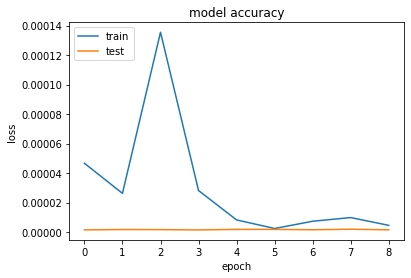

In [ ]:
print(history.history.keys())
# summarize history for accuracy
plt.plot(history.history['loss'][1:])
plt.plot(history.history['val_loss'][1:])
plt.title('model accuracy')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()


In [ ]:
pred_y

array([[0.00297412],
       [0.00281756],
       [0.00290158],
       ...,
       [0.00127758],
       [0.00118804],
       [0.00128496]], dtype=float32)

In [ ]:
correct = 0
for i in range(len(pred_y)):
  p = pred[i]>0
  t = t_test[i]>0

In [ ]:
y_test[:-72]

array([-1.18979256e-03, -1.18514294e-03, -9.88592527e-04, ...,
        7.40865954e-05,  6.60553277e-05,  2.04442603e-04])

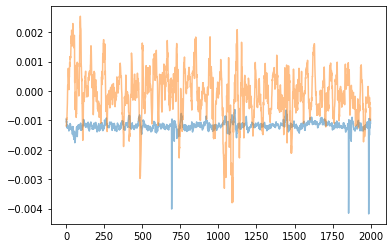

In [ ]:
plt.plot(pred_y[:2000], alpha=0.5)
plt.plot(y_test[:2000], alpha=0.5)

In [ ]:
np.dot((pred_y > 0).T, y_test[25:-72].reshape(-1,1) > 0)/len(pred_y)

array([[2.24497126e-05]])

In [ ]:
np.dot((pred_y > 0).T, y_test[25:-72].reshape(-1,1) > 0)

array([[ True]])

In [ ]:
pred_y > 0

array([[False],
       [False],
       [False],
       ...,
       [False],
       [False],
       [False]])

In [ ]:
pred_y

array([[-0.00096059],
       [-0.00098464],
       [-0.00106899],
       ...,
       [-0.00140578],
       [-0.00150296],
       [-0.00157361]], dtype=float32)

In [ ]:
y_test[25:-72]

array([9.39025817e-04, 1.16904631e-03, 1.07975000e-03, ...,
       7.40865954e-05, 6.60553277e-05, 2.04442603e-04])

In [ ]:
m.summary()

Model: "model_4"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_6 (InputLayer)           [(128, 30, 13)]      0           []                               
                                                                                                  
 lambda_5 (Lambda)              (128, 30, 13)        0           ['input_6[0][0]']                
                                                                                                  
 tcn_10 (TCN)                   (128, 30, 64)        139328      ['input_6[0][0]']                
                                                                                                  
 tcn_11 (TCN)                   (128, 30, 64)        139328      ['lambda_5[0][0]']               
                                                                                            